<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import Nets
from Nets import*

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

## measure decoding 

Decoding accuracy decreases, there are two possible reasons: 
1, decoding has bias,  information of position is only refleted by decoding, if there is certain bias , it is not trustable
2, it is the real measure of information, so there are less spatial information about space, or an effect decoupling/disentanglement of position. This can be due the network succeed at finding an even lower diemnsion object which gives successful performance.  The representation deceases its information to input in a sense. 

This can be linked to receptive field by looking at how space is represented. 

In [4]:
# Not distinguish the context, then train decoder, ** the middle increase of decoding error reflects appearence of context separation**
size = 15
for trial in [0]: 
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(0, 0))        
    weight = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec, prec_matrix = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(trial), prec_matrix)

clear session data 49 2685112320
1 4.401465865134685
decode train finish 4.378935337894208


In [6]:
size = 15
for trial in [0]: 
    Pretest =  PretrainTest(holes = 0, weight_write =  'weights_cpu8/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(1, 0))        
    weight = 'weights_cpu8/rnn_1515tanh512_checkpoint{}'.format(trial)
    Prec, prec_matrix = Pretest.decode(weight = weight, size_range = [size], size_test = [size], epsilon = 1)
    np.save('Dist{}'.format(49), prec_matrix)

clear session data 49 2685218816
1 4.06041349416573
decode train finish 4.014225566360517


In [16]:
prec_matrix0

array(7.74135819)

(0, 12)

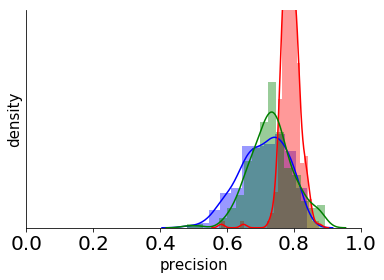

In [10]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')

prec_matrix0 = np.load('Dist0.npy')
prec_matrix300 = np.load('Dist300.npy')
prec_matrix49 = np.load('Dist49.npy')
# prec_matrixi = np.load('decode_integrator.npy')
sns.distplot(1 - np.array(prec_matrix0).ravel()/15, color = 'b', label = 'echo state')
sns.distplot(1 - np.array(prec_matrix300).ravel()/15, color = 'r', label = 'pretrained net300')
# sns.distplot(1 - np.array(prec_matrix39).ravel()/15, color = 'r', label = 'pretrained net39')
sns.distplot(1 - np.array(prec_matrix49).ravel()/15, color = 'g', label = 'pretrained net2')
# sns.distplot(1 - prec_matrixi.ravel()/15, color = 'k', label = 'integrator')
plt.xlim(0, 1)
plt.xticks(size = 20)
plt.xlabel('precision', size = 15)
plt.ylabel('density', size = 15)
# plt.legend( prop={'size': 12})
plt.yticks([])
plt.savefig('decodingdensity', dpi = 400)
plt.ylim(0, 12)

### Performance evolution
Measure evolution of three networks   

In [4]:
trial = 0
Performance_0 = []
for i in range(3):
    performance = []
    for j in range(11):
        if j == 0:
            Pretest = PretrainTest(weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        else:
            Pretest = PretrainTest(weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, i, j-1))
        Pretest.TestAllSizes(size_range = [15], limit_set = 4, test_size = [0])
        performance.append(Pretest.Performance)
    print (performance)
    Performance_0.append(performance)

[[-0.8780770344325428], [-0.8125], [-1.0], [-0.7433623120300752], [-0.034206033106449485], [0.40043547348437586], [0.7010520951504529], [0.6996673451800453], [0.833665445368776], [0.8657333075742902], [0.7855750984217631]]
[[-0.9453577898550725], [-0.591400588768116], [-0.3055044034800852], [-0.890625], [-0.07314342245354083], [0.3795241776954653], [0.6401778671874905], [0.7814103227379423], [0.7444963603776498], [0.8143142901258356], [0.7200610671092788]]
[[-0.8881395595860988], [-0.7834821428571428], [-0.6127400823910132], [0.0881306201162069], [0.5397243874711907], [0.5861678367557952], [0.7730880872487561], [0.8821695817518398], [0.9280895616627522], [0.9042759952251049], [0.913494183192628]]


In [82]:
trial = 0
Performance_0c = []
for i in range(3):
    performance = []
    for j in range(11):
        if j == 0:
             Pretest = PretrainTest(weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        else:
            Pretest = PretrainTest(weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, i, j-1))
        Pretest.TestAllSizes(size_range = [15], limit_set = 4, test_size = [0], cross = True)
        performance.append(Pretest.Performance)
    print (performance)
    Performance_0c.append(performance)

[[-0.82626344258596274], [-0.78125], [-1.0], [-0.68724670694561152], [-0.37602522641283315], [-0.10617402196981229], [-0.52822859829695767], [-0.52659718963970459], [-0.625], [-0.64104050244154775], [-0.70522460937499998]]
[[-0.79233908750480597], [-0.73802806712962965], [-0.42415374926745708], [-0.875], [0.00761144255556917], [-0.12032331291122589], [-0.49828972387566139], [-0.56483289930555558], [-0.437744140625], [-0.41045346467391303], [-0.390625]]
[[-0.87317293453839873], [-0.78125], [-0.75], [-0.30205512787184696], [-0.41372861781885467], [-0.28405694591853464], [-0.70458984375], [-0.734375], [-0.796875], [-0.765625], [-0.75]]


In [83]:
trial = 1
Performance_1 = []
for i in range(3):
    performance = []
    for j in range(11):
        if j == 0:
            Pretest = PretrainTest(weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        else:
            Pretest = PretrainTest(weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, i, j-1))
        Pretest.TestAllSizes(size_range = [15], limit_set = 4, test_size = [0])
        performance.append(Pretest.Performance)
    print (performance)
    Performance_1.append(performance)

[[-0.96875], [-0.29693163434552106], [-0.75], [-0.890625], [-0.57949838929217468], [0.14148045802554648], [0.37427302646219102], [0.62327531804589631], [0.84176825764125307], [0.87915237015606418], [0.90748679626082129]]
[[-0.94024367559523814], [-0.78125], [-1.0], [-0.984375], [-0.84954146967549449], [0.50019646308330146], [0.64136984491690097], [0.69863463043167306], [0.60559580008394143], [0.8430021114994406], [0.7587665910840139]]
[[-0.898436139010238], [-0.7418504050925927], [-0.75966101683746623], [0.013153280427596635], [0.55026811698711353], [0.64412965227385977], [0.80868221082171843], [0.7461013064768246], [0.84119082513446886], [0.87053835239591648], [0.85767984067300329]]


In [5]:
trial = 39
Performance_39 = []
for i in range(3):
    performance = []
    for j in range(11):
        if j == 0:
            Pretest = PretrainTest(weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        else:
            Pretest = PretrainTest(weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, i, j-1))
        Pretest.TestAllSizes(size_range = [15], limit_set = 4, test_size = 0)
        performance.append(Pretest.Performance)
    print (performance)
    Performance_39.append(performance)

[[-0.9059277895480227], [0.25419387810870403], [-0.6147459464555053], [-0.04210339500655404], [-0.13295365164131143], [0.6105312491115178], [0.8167130433513554], [0.720231967690683], [0.7972016949304277], [0.8189802292794058], [0.7820165631734053]]
[[-0.8207820154698593], [-0.39649629884004883], [-0.44232800098779945], [0.39372912716907715], [0.5997175692863305], [0.7640641532615291], [0.7232258757971634], [0.7481441371688371], [0.8255797450870311], [0.85364881348567], [0.792160262188514]]
[[-0.8831202651515151], [-0.07036752844684163], [-0.8125], [-0.6714859243449669], [0.39260735549469156], [0.7460461985870921], [0.8579945720507058], [0.8352571127988306], [0.8151844514288278], [0.7502162271309671], [0.754197773731033]]


In [16]:
trial = 39
Performance_39c = []
for i in range(3):
    performance = []
    for j in range(11):
        if j == 0:
            Pretest = PretrainTest(weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        else:
            Pretest = PretrainTest(weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, i, j-1))
        Pretest.TestAllSizes(size_range = [15], limit_set = 4, test_size = 0, cross = True)
        performance.append(Pretest.Performance)
    print (performance)
    Performance_39c.append(performance)

[[-0.90625], [-0.3502084328389039], [-0.6251423061628192], [-0.2456018527078609], [-0.4758825380263799], [-0.13747009307974312], [0.004788861377542787], [-0.08604215009160293], [-0.13328492305867162], [-0.03371012874107421], [-0.18685625703263312]]
[[-0.914900097465887], [-0.6202972808441558], [-0.4829272213968847], [-0.2497830683664783], [-0.03240510987165922], [-0.17645481206171543], [-0.42469270996821573], [-0.20661282543998977], [-0.6145241477272727], [-0.3965039375734419], [0.18528060370418287]]
[[-0.9127604166666667], [-0.3778732757985127], [-0.78125], [-0.5558207386433451], [-0.034040935245515686], [-0.051900362617220974], [-0.08901624189041946], [-0.32068249293088447], [-0.4456170813740857], [-0.14010427787811763], [0.04799571655649676]]


In [101]:
trial = 1
Performance_1c = []
for i in range(3):
    performance = []
    for j in range(11):
        if j == 0:
            Pretest = PretrainTest(weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        else:
            Pretest = PretrainTest(weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, i, j-1))
        Pretest.TestAllSizes(size_range = [15], limit_set = 4, test_size = [0], cross = True)
        performance.append(Pretest.Performance)
    print (performance)
    Performance_1c.append(performance)

[[-0.95793547453703698], [-0.70923608754465373], [-0.75], [-0.890625], [-0.875], [-0.3451607057015339], [0.0059970117397362549], [-0.051832772730447063], [-0.30168123422942544], [-0.37552553192276722], [-0.33016065633989927]]
[[-0.94443873355263164], [-0.84375], [-1.0], [-0.984375], [-0.55045913661477497], [-0.4814703128661203], [-0.039325449910155449], [-0.25681790322768111], [-0.36133424055971536], [-0.056569896940698278], [-0.063982332831022032]]
[[-0.90900440705128205], [-0.8623046875], [-0.8286313657407407], [-0.41094313902575835], [-0.26303374851841421], [-0.45747070312500004], [-0.34899142469780736], [-0.16035364310597983], [-0.28920426371444607], [-0.36685809036883255], [-0.32526773763346029]]


In [5]:
np.save('performance_0', Performance_0)

In [17]:
# np.save('performance_0c', Performance_0c)
# np.save('performance_1', Performance_1)
# np.save('performance_1c', Performance_1c)
np.save('performance_39', Performance_39)
np.save('performance_39c', Performance_39c)

In [55]:
np.load('performance_integrator.npy')[::4]

array([-0.94666667, -0.68782441,  0.03091875,  0.40772265,  0.42803629,
        0.80068308,  0.82975333,  0.83309182,  0.92166926,  0.91965327])

In [33]:
Performance_q_learn = np.load('Performance_pretrain_stim.npy')
P = np.array([perform.ravel() for perform in Performance_q_learn])
P
np.mean(P, axis = 0)

array([-0.95625   , -0.73548232, -0.75701601, -0.64826417, -0.59645842,
       -0.1877177 , -0.37928187, -0.36221714, -0.43912674, -0.28297408,
       -0.08800147])

In [17]:
Performance_q_learn.shape

(3, 11, 1)

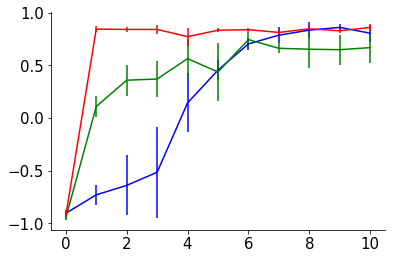

In [36]:
def Ravel(vect):
    return [v[0] for v in vect]

ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Performance_q_learn = np.load('performance_0.npy')
# perform_matrix_0 = np.array([Ravel(perform) for perform in Performance_q_learn])
plt.errorbar(x = np.arange(11), y = np.mean(Performance_q_learn, axis = 0), yerr = np.std(Performance_q_learn, axis = 0),
             color = 'b', label = 'Mem')

# Performance_q_learn = np.load('performance_39.npy')
# # perform_matrix_0 = np.array([Ravel(perform) for perform in Performance_q_learn])
# plt.plot(np.mean(Performance_q_learn, axis = 0), 'r', label = 'Opt')


Performance_q_learn = np.load('Performance_pre2.npy')
plt.errorbar(x = np.arange(11), y = np.mean(Performance_q_learn, axis = 0), yerr = np.std(Performance_q_learn, axis = 0),
             color = 'g', label = 'Mem')

Performance_q_learn = np.load('Performance_4.npy')
# perform_matrix_0 = np.array([Ravel(perform) for perform in Performance_q_learn])

plt.errorbar(x = np.arange(11), y = np.mean(Performance_q_learn, axis = 0), yerr = np.std(Performance_q_learn, axis = 0),
             color = 'r', label = 'Mem')
# plt.xlabel('iterations')
# plt.ylabel('performance')
# plt.legend()

plt.yticks([-1, -0.5, 0, 0.5, 1], size = 15)
plt.xticks(size = 15)
# plt.yticks([-1, -0 ])
plt.savefig('perfixsize', dpi = 400)